**Visualización de la Muestra:**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from kmodes.kprototypes import KPrototypes
import kmodes.util 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import PowerTransformer
import pandas as pd
import seaborn as sns
plt.style.use("_classic_test_patch")
df_sample = pd.read_excel("samples_2d.xlsx")
df_sample.head()

,X,Y,Ley,Rocktype,Rock_1,Rock_2
0,510,659,1.916250,0,0,1
1,550,669,2.188077,0,0,1
2,570,739,1.915897,0,0,1
3,330,499,2.054625,0,0,1
4,320,609,1.840287,0,0,1


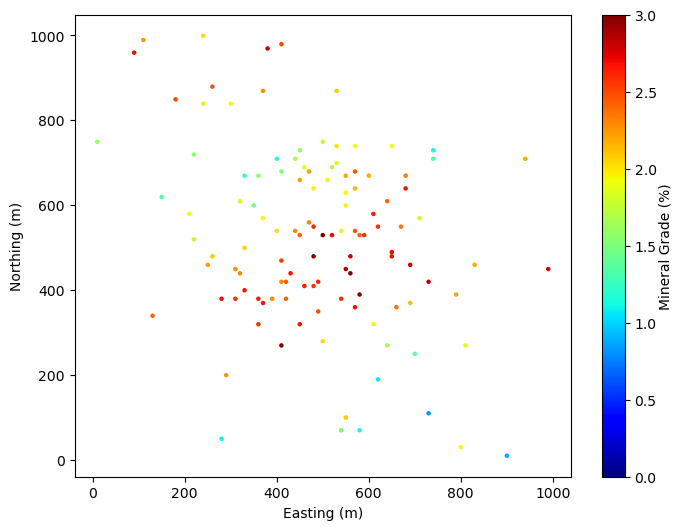

In [2]:
plt.figure(figsize=(8, 6))
marker_size = 5
min_value = 0
plt.scatter(df_sample["X"], df_sample["Y"], marker_size, df_sample["Ley"], vmin=min_value, cmap="jet", marker="o")
cbar = plt.colorbar()
cbar.set_label("Mineral Grade (%)", labelpad=1)
plt.clim(0,3)
plt.grid(False)
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.show()

In [3]:
df = pd.read_csv("resultados.csv", sep=";")
df.head()

,ko,ko average sample distance,ko krig_var,ko n samples
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN


In [4]:
grid_x = np.linspace(10,1010, num=50, endpoint=False) #Coord. de origen x, coord. de termino x, nª de celdas x.
grid_y = np.linspace(10,1010, num=50, endpoint=False) #Coord. de origen y, coord. de termino y, nª de celdas y.
gy = np.array(grid_y) #conversión a un array de numpy 
gx = np.array(grid_x) #conversión a un array de numpy 
yg, xg = np.meshgrid(grid_x, grid_y, indexing='ij') #Creación de la grilla (intersecciones en yg; xg)
x_g = xg.ravel() #aplanamiento de xg
y_g = yg.ravel() #aplanamiento de yg
d = {'X': x_g, 'Y': y_g} #Columnas con coordenadas X e Y.
df1 = pd.DataFrame(data=d) #Creación del dataframe     
df["X"] = df1["X"]
df["Y"] = df1["Y"]
df.head()

,ko,ko average sample distance,ko krig_var,ko n samples,X,Y
0,NaN,NaN,NaN,NaN,10.0,10.0
1,NaN,NaN,NaN,NaN,30.0,10.0
2,NaN,NaN,NaN,NaN,50.0,10.0
3,NaN,NaN,NaN,NaN,70.0,10.0
4,NaN,NaN,NaN,NaN,90.0,10.0


In [5]:
df.replace(-99, np.nan, inplace=True)
df= df.dropna()
df.head()

,ko,ko average sample distance,ko krig_var,ko n samples,X,Y
133,1.19737,119.423,0.309090,6.0,670.0,50.0
134,1.19485,119.771,0.313933,5.0,690.0,50.0
182,1.10442,99.171,0.283412,5.0,650.0,70.0
183,1.15411,110.082,0.295798,5.0,670.0,70.0
184,1.14318,112.859,0.278678,5.0,690.0,70.0


In [12]:
df['calidad_code'] = df['ko krig_var'].apply(lambda x: 0 if x < 0.08 else 1)
df["cov"] = (np.sqrt(df["ko krig_var"])/df["ko"])
df.head()

,ko,ko average sample distance,ko krig_var,ko n samples,X,Y,calidad_code,cov
133,1.19737,119.423,0.309090,6.0,670.0,50.0,1,0.464316
134,1.19485,119.771,0.313933,5.0,690.0,50.0,1,0.468927
182,1.10442,99.171,0.283412,5.0,650.0,70.0,1,0.482031
183,1.15411,110.082,0.295798,5.0,670.0,70.0,1,0.471249
184,1.14318,112.859,0.278678,5.0,690.0,70.0,1,0.461782


In [9]:
def actualizar_calidad(df):
    df_actualizado = df.copy()
    for index, row in df.iterrows():
        x, y, calidad = row['X'], row['Y'], row['calidad_code']
        h=20 #indicar tamaño de bloques
        indices_circundantes = ((df['X'] == x - h) & (df['Y'] == y)) | \
                               ((df['X'] == x - 2*h) & (df['Y'] == y)) | \
                               ((df['X'] == x + h) & (df['Y'] == y)) | \
                               ((df['X'] == x + 2*h) & (df['Y'] == y)) | \
                               ((df['X'] == x) & (df['Y'] == y - h)) | \
                               ((df['X'] == x) & (df['Y'] == y - 2*h)) | \
                               ((df['X'] == x) & (df['Y'] == y + h)) | \
                               ((df['X'] == x) & (df['Y'] == y + 2*h)) | \
                               ((df['X'] == x - h) & (df['Y'] == y - h)) | \
                               ((df['X'] == x - 2*h) & (df['Y'] == y - h)) | \
                               ((df['X'] == x - 2*h) & (df['Y'] == y - 2*h)) | \
                               ((df['X'] == x - h) & (df['Y'] == y - 2*h)) | \
                               ((df['X'] == x - h) & (df['Y'] == y + h)) | \
                               ((df['X'] == x - 2*h) & (df['Y'] == y + h)) | \
                               ((df['X'] == x - h) & (df['Y'] == y + 2*h)) | \
                               ((df['X'] == x - 2*h) & (df['Y'] == y + 2*h)) | \
                               ((df['X'] == x + h) & (df['Y'] == y - h)) | \
                               ((df['X'] == x + h) & (df['Y'] == y - 2*h)) | \
                               ((df['X'] == x + 2*h) & (df['Y'] == y - h)) | \
                               ((df['X'] == x + 2*h) & (df['Y'] == y - 2*h)) | \
                               ((df['X'] == x + h) & (df['Y'] == y + h)) | \
                               ((df['X'] == x + 2*h) & (df['Y'] == y + h)) | \
                               ((df['X'] == x + h) & (df['Y'] == y + 2*h)) | \
                               ((df['X'] == x + 2*h) & (df['Y'] == y + 2*h))
        porcentaje_otras_categorias = np.mean(df.loc[indices_circundantes, 'calidad_code'] != calidad)
        if porcentaje_otras_categorias > 0.51:
            categorias_circundantes = df.loc[indices_circundantes, 'calidad_code']
            nueva_categoria = categorias_circundantes.mode().iloc[0]
            df_actualizado.at[index, 'calidad_code'] = nueva_categoria
    return df_actualizado

In [10]:
df_calidad = actualizar_calidad(df)
df_calidad2 = actualizar_calidad(df_calidad)
df_calidad3 = actualizar_calidad(df_calidad2)
df["confianza"] = df_calidad3["calidad_code"]

In [12]:
df['confianza_geo'] = df['confianza'].map({0: 'baja', 1: 'alta'})
df.head()

,ko,ko average sample distance,ko krig_var,ko n samples,X,Y,calidad_code,confianza,confianza_geo
133,1.19737,119.423,0.309090,6.0,670.0,50.0,1,1,alta
134,1.19485,119.771,0.313933,5.0,690.0,50.0,1,1,alta
182,1.10442,99.171,0.283412,5.0,650.0,70.0,1,1,alta
183,1.15411,110.082,0.295798,5.0,670.0,70.0,1,1,alta
184,1.14318,112.859,0.278678,5.0,690.0,70.0,1,1,alta


In [13]:
variables_deseadas = ["ko average sample distance", "ko krig_var", "ko n samples"]
nuevo_df1 = df[variables_deseadas].copy()
pt = PowerTransformer()
X_transformed = pt.fit_transform(nuevo_df1)
nuevo_df = pd.DataFrame(X_transformed, columns=variables_deseadas)
nuevo_df["calidad"] = df["confianza_geo"].values
nuevo_df.head()

,ko average sample distance,ko krig_var,ko n samples,calidad
0,1.467530,2.219870,-1.195824,alta
1,1.484746,2.255433,-1.604855,alta
2,0.396621,2.019533,-1.604855,alta
3,0.991292,2.118714,-1.604855,alta
4,1.135819,1.980311,-1.604855,alta


In [14]:
kproto = KPrototypes(n_clusters=3, init='Huang', n_jobs = 4, random_state=17276365)
clusters_kproto = kproto.fit_predict(nuevo_df, categorical=[3])

In [15]:
df["Categoria"] = clusters_kproto
df.head()

,ko,ko average sample distance,ko krig_var,ko n samples,X,Y,calidad_code,confianza,confianza_geo,Categoria
133,1.19737,119.423,0.309090,6.0,670.0,50.0,1,1,alta,1
134,1.19485,119.771,0.313933,5.0,690.0,50.0,1,1,alta,1
182,1.10442,99.171,0.283412,5.0,650.0,70.0,1,1,alta,1
183,1.15411,110.082,0.295798,5.0,670.0,70.0,1,1,alta,1
184,1.14318,112.859,0.278678,5.0,690.0,70.0,1,1,alta,1


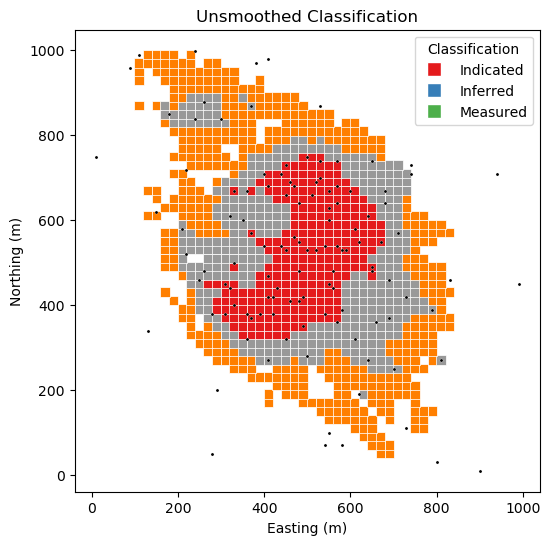

In [16]:
plt.figure(figsize=(6, 6))
marker_size = 45
marker_size2 = 5
palette1 = sns.color_palette("Set1", as_cmap=True)
scatterplot1 = sns.scatterplot(x=df["X"], y=df["Y"], hue=df["Categoria"], palette=palette1, s=marker_size, marker="s")
scatterplot2 = sns.scatterplot(x=df_sample["X"], y=df_sample["Y"], color="black", s=marker_size2, marker="o")
labels_dict = {0: "Measured", 1: "Indicated", 2: "Inferred"}
labels = [labels_dict[val] for val in df["Categoria"].unique()]
legend_elements = [plt.Line2D([0], [0], marker='s', color='w', label=label, markersize=10, markerfacecolor=palette1(i)) for i, label in enumerate(labels)]
scatterplot1.legend(handles=legend_elements, title="Classification", labels=labels)
plt.title("Unsmoothed Classification")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.show()

**MODELO DE SUAVIZADO POR RNA:**

In [18]:
X = df[['X', 'Y']]
y = df['Categoria']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
model = Sequential()
model.add(Dense(128, input_dim=2, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))  # 3 neuronas de salida para las tres categorías
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])
predictions = model.predict(X_test)
predicted_categories = np.argmax(predictions, axis=1)

Epoch 1/200
26/26 [==============================] - 1s 13ms/step - loss: 0.9805 - accuracy: 0.4146 - val_loss: 0.9173 - val_accuracy: 0.4878
Epoch 2/200
26/26 [==============================] - 0s 4ms/step - loss: 0.9029 - accuracy: 0.4963 - val_loss: 0.8539 - val_accuracy: 0.5610
Epoch 3/200
26/26 [==============================] - 0s 4ms/step - loss: 0.8518 - accuracy: 0.5732 - val_loss: 0.7983 - val_accuracy: 0.6780
Epoch 4/200
26/26 [==============================] - 0s 4ms/step - loss: 0.7914 - accuracy: 0.6439 - val_loss: 0.7384 - val_accuracy: 0.7610
Epoch 5/200
26/26 [==============================] - 0s 4ms/step - loss: 0.7291 - accuracy: 0.7146 - val_loss: 0.6539 - val_accuracy: 0.7805
Epoch 6/200
26/26 [==============================] - 0s 4ms/step - loss: 0.6664 - accuracy: 0.7451 - val_loss: 0.5750 - val_accuracy: 0.8390
Epoch 7/200
26/26 [==============================] - 0s 4ms/step - loss: 0.6092 - accuracy: 0.7634 - val_loss: 0.5185 - val_accuracy: 0.8488
Epoch 8/200


Epoch 59/200
26/26 [==============================] - 0s 2ms/step - loss: 0.3222 - accuracy: 0.8646 - val_loss: 0.2733 - val_accuracy: 0.8780
Epoch 60/200
26/26 [==============================] - 0s 3ms/step - loss: 0.3245 - accuracy: 0.8683 - val_loss: 0.2708 - val_accuracy: 0.8634
Epoch 61/200
26/26 [==============================] - 0s 5ms/step - loss: 0.3252 - accuracy: 0.8659 - val_loss: 0.2658 - val_accuracy: 0.9122
Epoch 62/200
26/26 [==============================] - 0s 4ms/step - loss: 0.3101 - accuracy: 0.8768 - val_loss: 0.2555 - val_accuracy: 0.9073
Epoch 63/200
26/26 [==============================] - 0s 3ms/step - loss: 0.3140 - accuracy: 0.8707 - val_loss: 0.2556 - val_accuracy: 0.9122
Epoch 64/200
26/26 [==============================] - 0s 4ms/step - loss: 0.3123 - accuracy: 0.8695 - val_loss: 0.2610 - val_accuracy: 0.9073
Epoch 65/200
26/26 [==============================] - 0s 4ms/step - loss: 0.3132 - accuracy: 0.8768 - val_loss: 0.2509 - val_accuracy: 0.8634
Epoch 

In [19]:
X_original = df[['X', 'Y']]
X_original = scaler.transform(X_original)
predictions_original = model.predict(X_original)
predicted_categories_original = np.argmax(predictions_original, axis=1)
df['Categoria_s_original'] = predicted_categories_original

33/33 [==============================] - 0s 800us/step


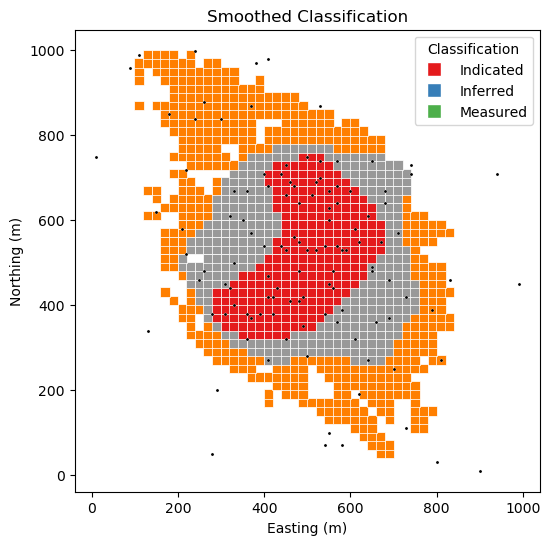

In [22]:
plt.figure(figsize=(6, 6))
marker_size = 45
marker_size2 = 5
palette1 = sns.color_palette("Set1", as_cmap=True)
scatterplot1 = sns.scatterplot(x=df["X"], y=df["Y"], hue=df["Categoria_s_original"], palette=palette1, s=marker_size, marker="s")
scatterplot2 = sns.scatterplot(x=df_sample["X"], y=df_sample["Y"], color="black", s=marker_size2, marker="o")
labels_dict = {0: "Measured", 1: "Indicated", 2: "Inferred"}
labels = [labels_dict[val] for val in df["Categoria_s_original"].unique()]
legend_elements = [plt.Line2D([0], [0], marker='s', color='w', label=label, markersize=10, markerfacecolor=palette1(i)) for i, label in enumerate(labels)]
scatterplot1.legend(handles=legend_elements, title="Classification", labels=labels)
plt.title("Smoothed Classification")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.show()

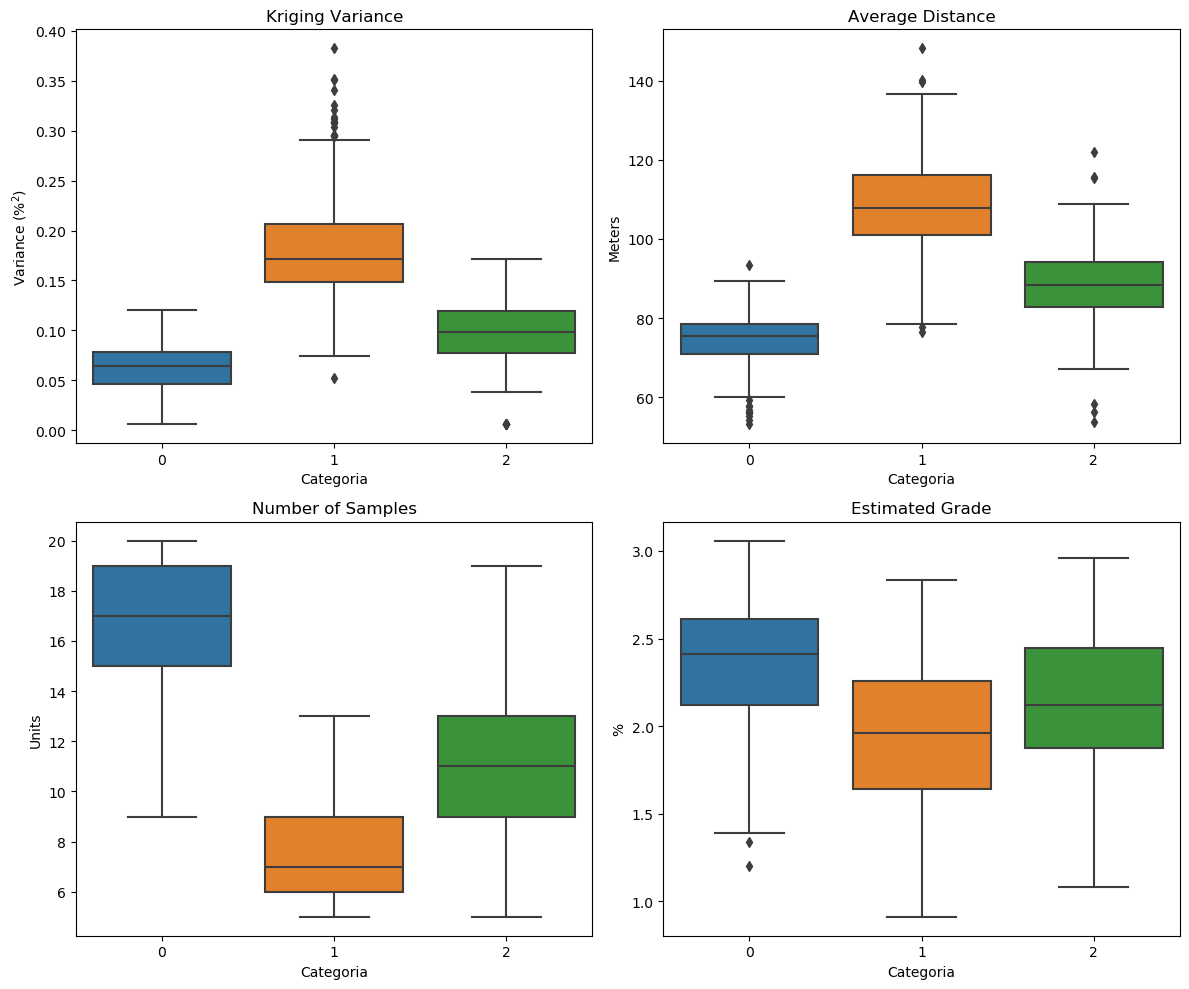

In [99]:
columnas_interes = ['ko krig_var', 'ko average sample distance', 'ko n samples', 'ko']
df_seleccionado = df[columnas_interes]
nombre_eje_x = 'Categoria'
nombres_etiquetas = ['Kriging Variance', 'Average Distance', 'Number of Samples', 'Estimated Grade']
nombres_eje_y = ['Variance (%$^2$)', 'Meters', 'Units', '%']
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
for i, columna in enumerate(df_seleccionado.columns):
    sns.boxplot(x=nombre_eje_x, y=columna, data=df, ax=axs[i // 2, i % 2])
    axs[i // 2, i % 2].set_title(nombres_etiquetas[i])
    axs[i // 2, i % 2].set_xlabel(nombre_eje_x)
    axs[i // 2, i % 2].set_ylabel(nombres_eje_y[i])  # Utilizar el nombre del eje Y especificado
plt.tight_layout()
plt.show()

C:\TEMP\ipykernel_15056\1124854544.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_seleccionado['calidad_code'] = df_seleccionado['calidad_code'].replace({0: 'High', 1: 'Low'})


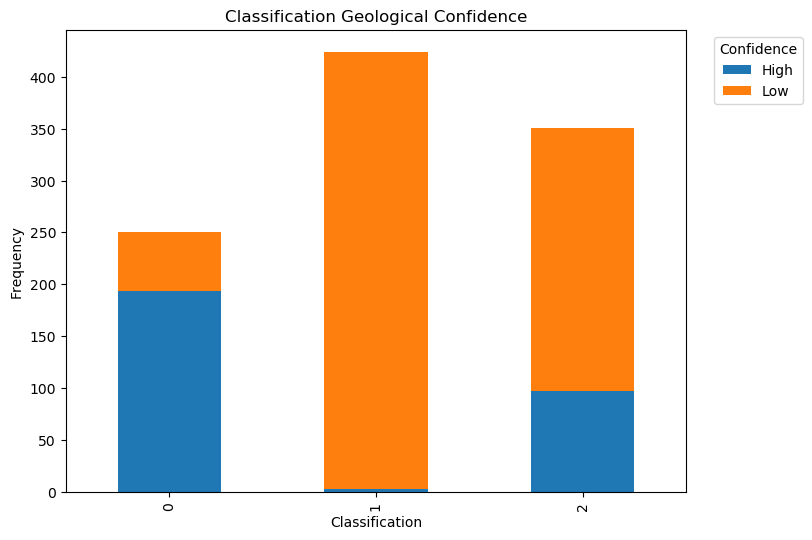

In [117]:
columnas_interes = ['calidad_code', 'Categoria']
df_seleccionado = df[columnas_interes]
df_seleccionado['calidad_code'] = df_seleccionado['calidad_code'].replace({0: 'High', 1: 'Low'})
conteo_calidad_por_categoria = df_seleccionado.groupby(['Categoria', 'calidad_code']).size().unstack()
conteo_calidad_por_categoria.plot(kind='bar', stacked=True, figsize=(8, 6))
plt.title('Classification Geological Confidence')
plt.xlabel('Classification')
plt.ylabel('Frequency')
plt.legend(title='Confidence', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()